# Estimated Phytoplankton Size

```{glue:figure} average_map
:scale: 50%
:align: center
```

```{glue:figure} average_timeseries
:scale: 50%
:align: center
```

**Figure. Estimated Median Phytoplankton Size from satellite.**  The map (top) shows the change in the estimated median phytoplankton size (μm equivalent spherical diameter, ESD) in the vicinity of Palau over the period 1998-2023 derived from satellite remotely sensed sea surface temperature and ocean color data.  The grey line is the Palau EEZ.  The line plot (bottom) shows the change in the estimated median phytoplankton size  (μm ESD) averaged over the area within the top plot.  The black line represents the trend, which is not statistically significant (p > 0.05).

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import os.path as op
import sys

import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from myst_nb import glue 

sys.path.append("../../../../indicators_setup")

from ind_setup.plotting_int import plot_timeseries_interactive, plot_oni_index_th
from ind_setup.plotting import plot_base_map, plot_map_subplots, add_oni_cat, plot_bar_probs, fontsize

sys.path.append("../../../functions")
from data_downloaders import download_ERDDAP_data, download_oni_index




## Setup

Define area of interest

In [2]:
#Area of interest
lon_range  = [129.4088, 137.0541]
lat_range = [1.5214, 11.6587]

EEZ shapefile

In [3]:
shp_f = op.join(os.getcwd(), '..', '..','..', 'data/Palau_EEZ/pw_eez_pol_april2022.shp')
shp_eez = gpd.read_file(shp_f)

## Download Data

DATASET: https://oceanwatch.pifsc.noaa.gov/erddap/info/md50_exp/index.html


In [ ]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

In [5]:
base_url = 'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/md50_exp.csv'
dataset_id = 'MD50'

if update_data:
    date_ini = '1998-01-01T00:00:00Z'
    date_end = '2024-12-01T00:00:00Z'
    data = download_ERDDAP_data(base_url, dataset_id, date_ini, date_end, lon_range, lat_range)
    data_xr = data.set_index(['latitude', 'longitude', 'time']).to_xarray()
    data_xr['time'] = pd.to_datetime(data_xr.time)
    data_xr = data_xr.coarsen(longitude=2, latitude=2, boundary = 'pad').mean()
    data_xr.to_netcdf(op.join(path_data, f'griddap_{dataset_id}.nc'))
else:
    data_xr = xr.open_dataset(op.join(path_data, f'griddap_{dataset_id}.nc'))

## Analysis

### Plotting

#### Average

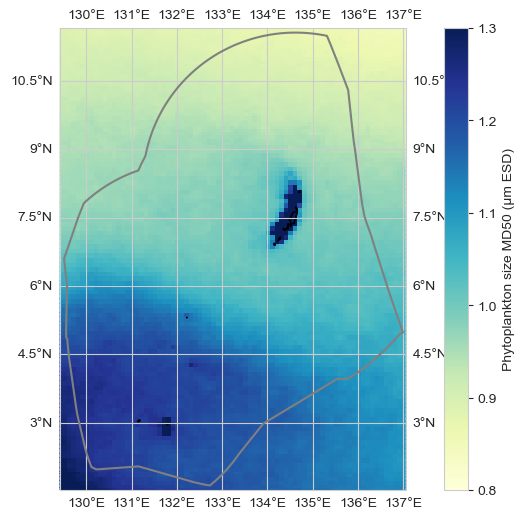

In [6]:
fig, ax = plot_base_map(shp_eez = shp_eez, figsize = [10, 6])
im = ax.pcolor(data_xr.longitude, data_xr.latitude, data_xr.mean(dim='time')[dataset_id], transform=ccrs.PlateCarree(), 
                cmap = 'YlGnBu', vmin = 0.8, vmax = 1.3)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
plt.colorbar(im, ax=ax, label='Phytoplankton size MD50 (µm ESD)')
glue("average_map", fig, display=False)
plt.savefig(op.join(path_figs, 'F16_phytoplankton_mean_map.png'), dpi=300, bbox_inches='tight')


#### Annual average

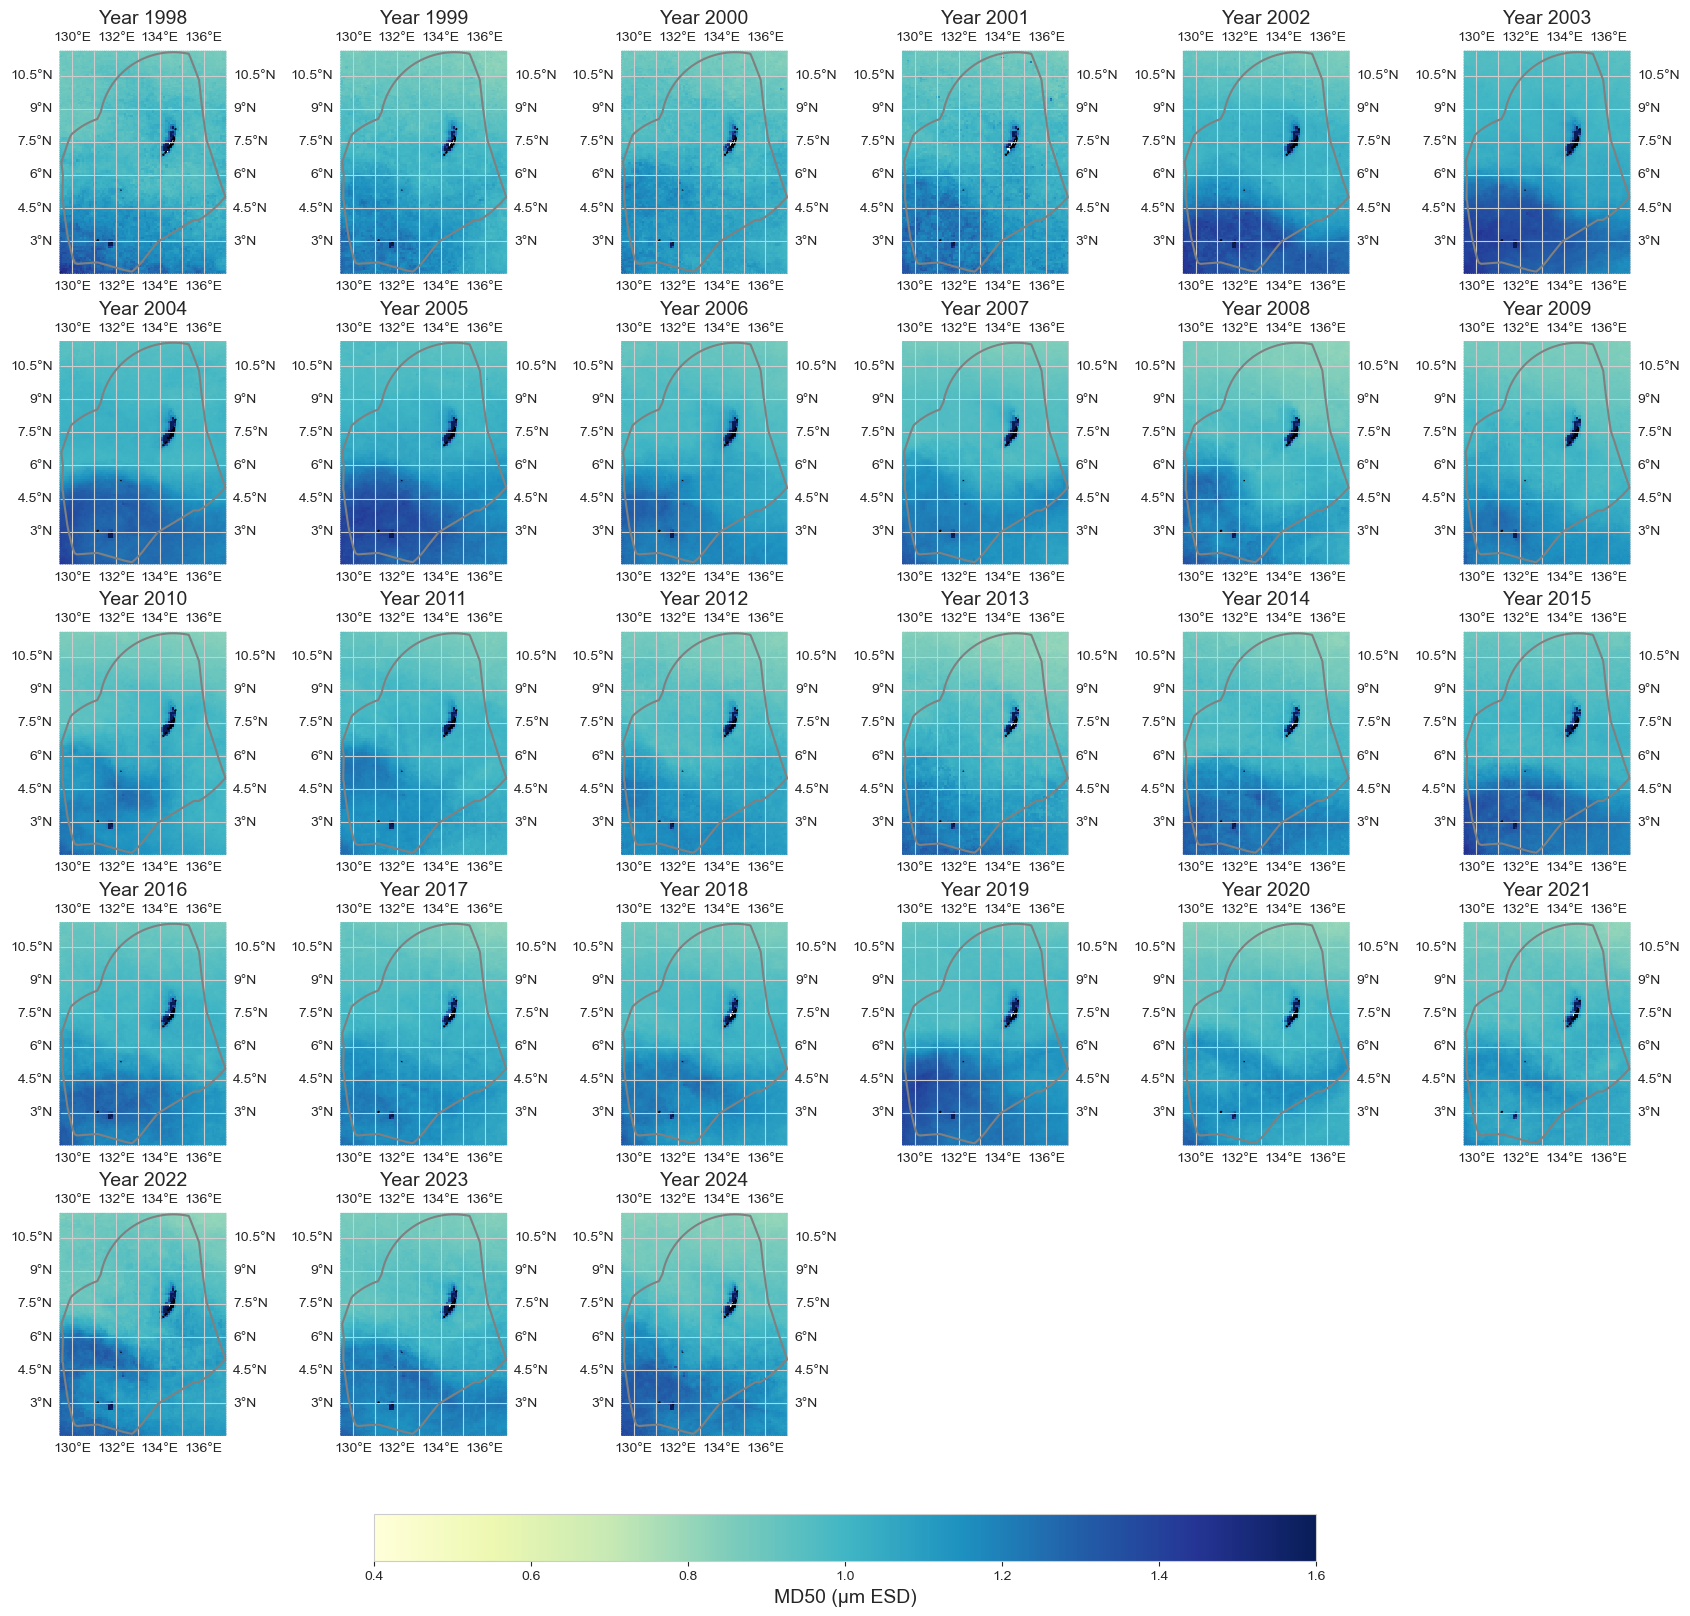

In [7]:
data_y = data_xr.resample(time='1YE').mean()
fig = plot_map_subplots(data_y, 'MD50', shp_eez = shp_eez, cmap = 'YlGnBu', vmin = 0.4, vmax = 1.6, cbar = 1)

#### Annual anomaly

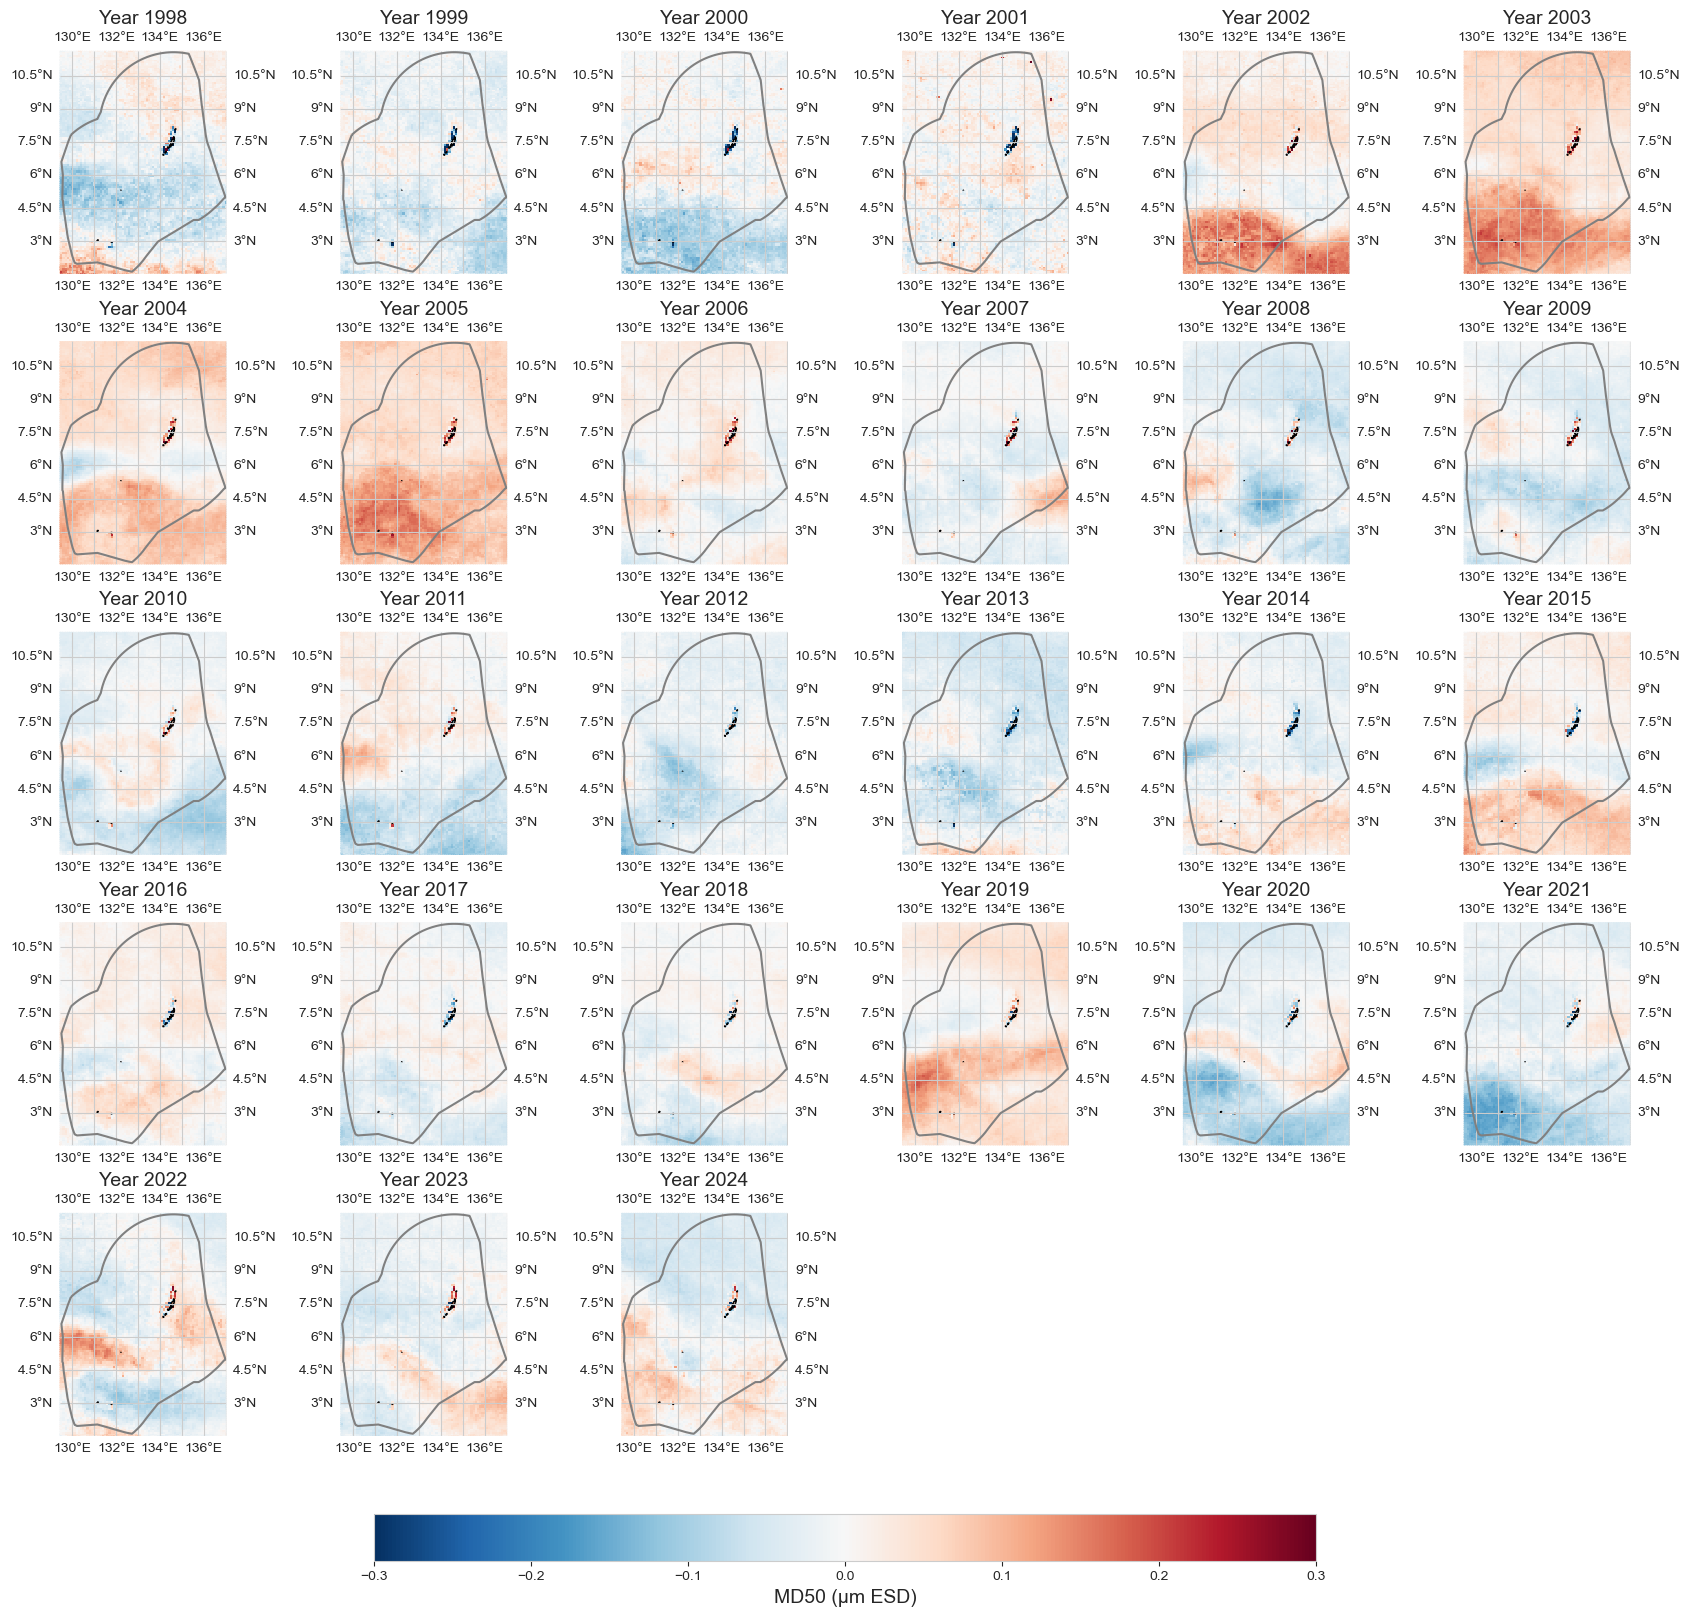

In [8]:
data_an = data_y - data_xr.mean(dim='time')
fig = plot_map_subplots(data_an, dataset_id, shp_eez = shp_eez, cmap='RdBu_r', vmin=-.3, vmax=.3, cbar = 1)

#### Average over area

In [9]:
dict_plot = [{'data' : data_xr.mean(dim = ['longitude', 'latitude']).to_dataframe(), 
              'var' : dataset_id, 'ax' : 1, 'label' : 'Median Phytoplankton Size - MEAN AREA'},]

In [10]:
fig = plot_timeseries_interactive(dict_plot, trendline=True, scatter_dict = None, figsize = (25, 12), 
                                 label_yaxes = 'Phytoplankton MD50 (µm ESD)');
fig.write_html(op.join(path_figs, 'F16_phytoplankton_mean_trend.html'), include_plotlyjs="cdn")


#### Timeseries at a given point

In [12]:
loc = [7.35, 134.48]
dict_plot = [{'data' : data_xr.sel(longitude=loc[1], latitude=loc[0], method='nearest').to_dataframe(), 
              'var' : dataset_id, 'ax' : 1, 'label' : f'Median Phytoplankton Size at [{loc[0]}, {loc[1]}]'},]

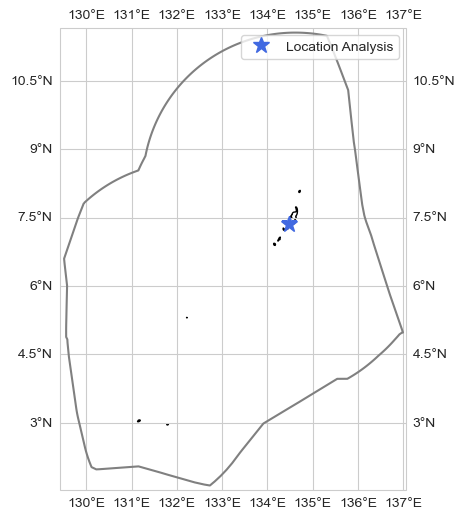

In [13]:
fig, ax = plot_base_map(shp_eez = shp_eez, figsize = [10, 6])
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
ax.plot(loc[1], loc[0], '*', markersize = 12, color = 'royalblue', transform=ccrs.PlateCarree(), label = 'Location Analysis')
ax.legend()

In [14]:
fig = plot_timeseries_interactive(dict_plot, trendline=True, scatter_dict = None, figsize = (25, 12),
                                 label_yaxes = 'Phytoplankton MD50 (µm ESD)');

### ONI index analysis

In [15]:
if update_data:
    p_data = 'https://psl.noaa.gov/data/correlation/oni.data'
    df1 = download_oni_index(p_data)
    df1.to_pickle(op.join(path_data, 'oni_index.pkl'))
else:
    df1 = pd.read_pickle(op.join(path_data, 'oni_index.pkl'))

In [16]:
lims = [-.5, .5]
plot_oni_index_th(df1, lims = lims)

Group by ONI category

In [17]:
df1 = add_oni_cat(df1, lims = lims)
df1['ONI'] = df1['oni_cat']
data_xr['ONI'] = (('time'), df1.iloc[np.intersect1d(data_xr.time, df1.index, return_indices=True)[2]].ONI.values)
data_xr['ONI_cat'] = (('time'), np.where(data_xr.ONI < lims[0], -1, np.where(data_xr.ONI > lims[1], 1, 0)))
data_oni = data_xr.groupby('ONI_cat').mean()

#### Average

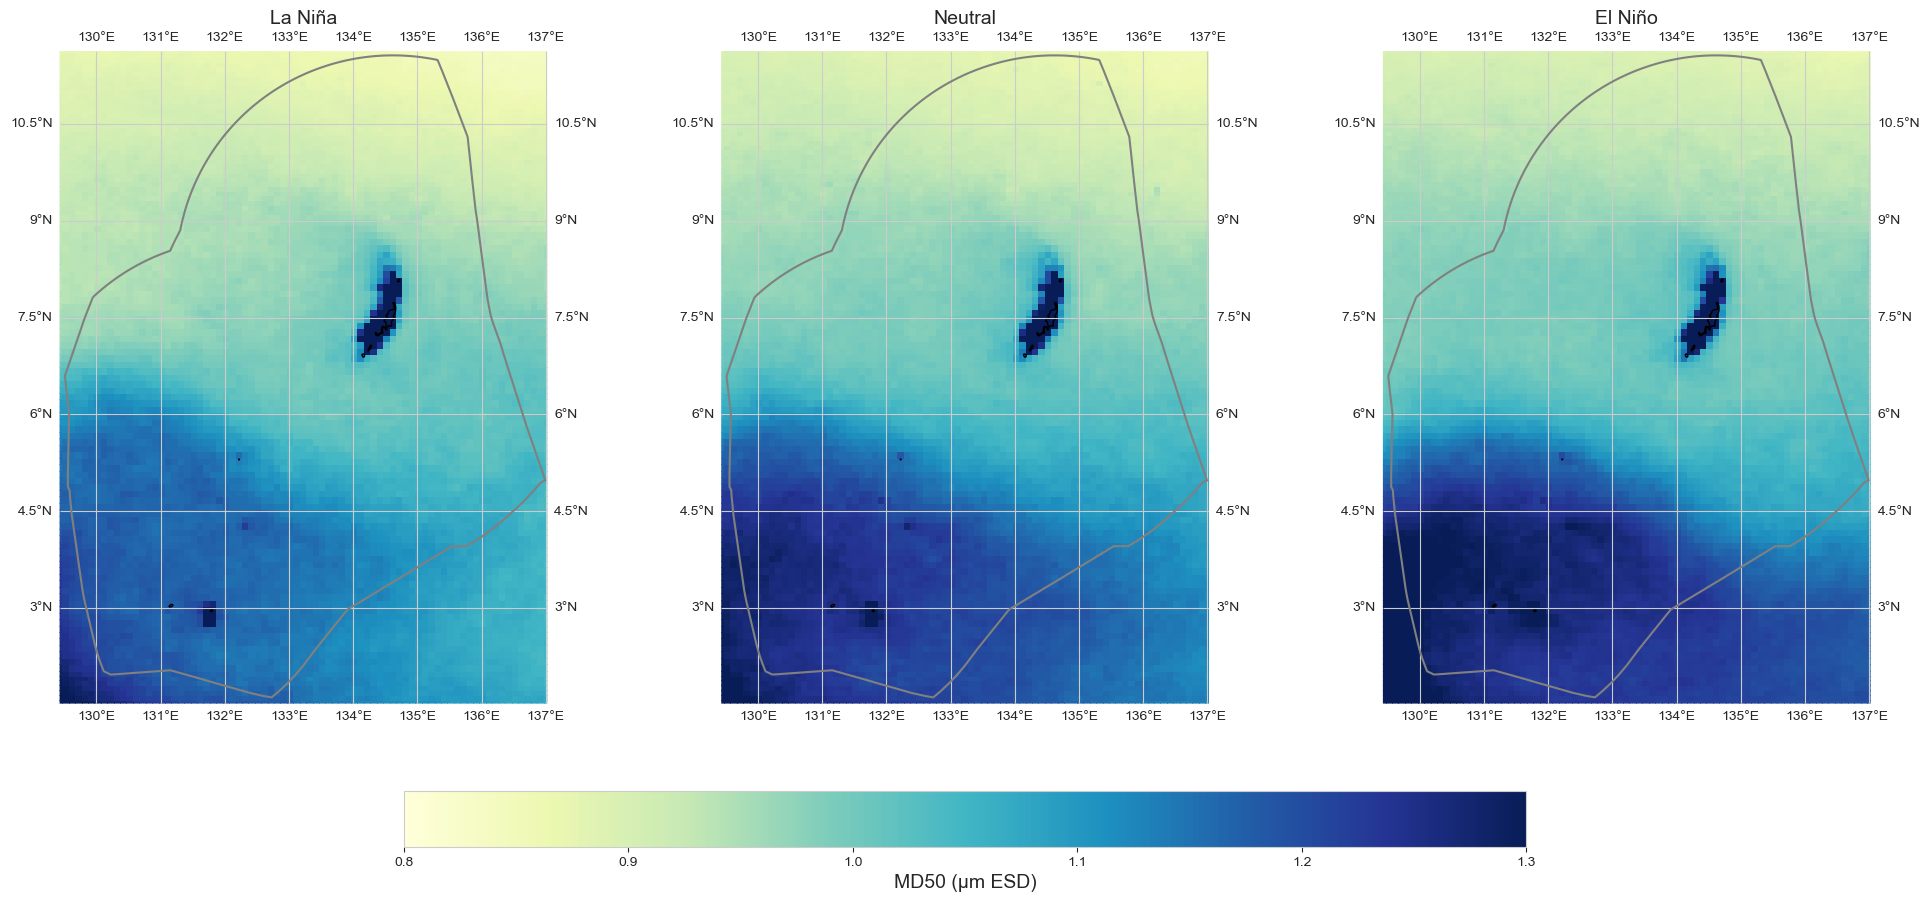

In [18]:
fig = plot_map_subplots(data_oni, dataset_id, shp_eez = shp_eez, cmap = 'YlGnBu', vmin = 0.8, vmax = 1.3, 
                  sub_plot= [1, 3], figsize = (20, 9),  cbar = True, cbar_pad = 0.1,
                  titles = ['La Niña', 'Neutral', 'El Niño'],)
plt.savefig(op.join(path_figs, 'F16_phytoplankton_ENSO.png'), dpi=300, bbox_inches='tight')


#### Anomaly

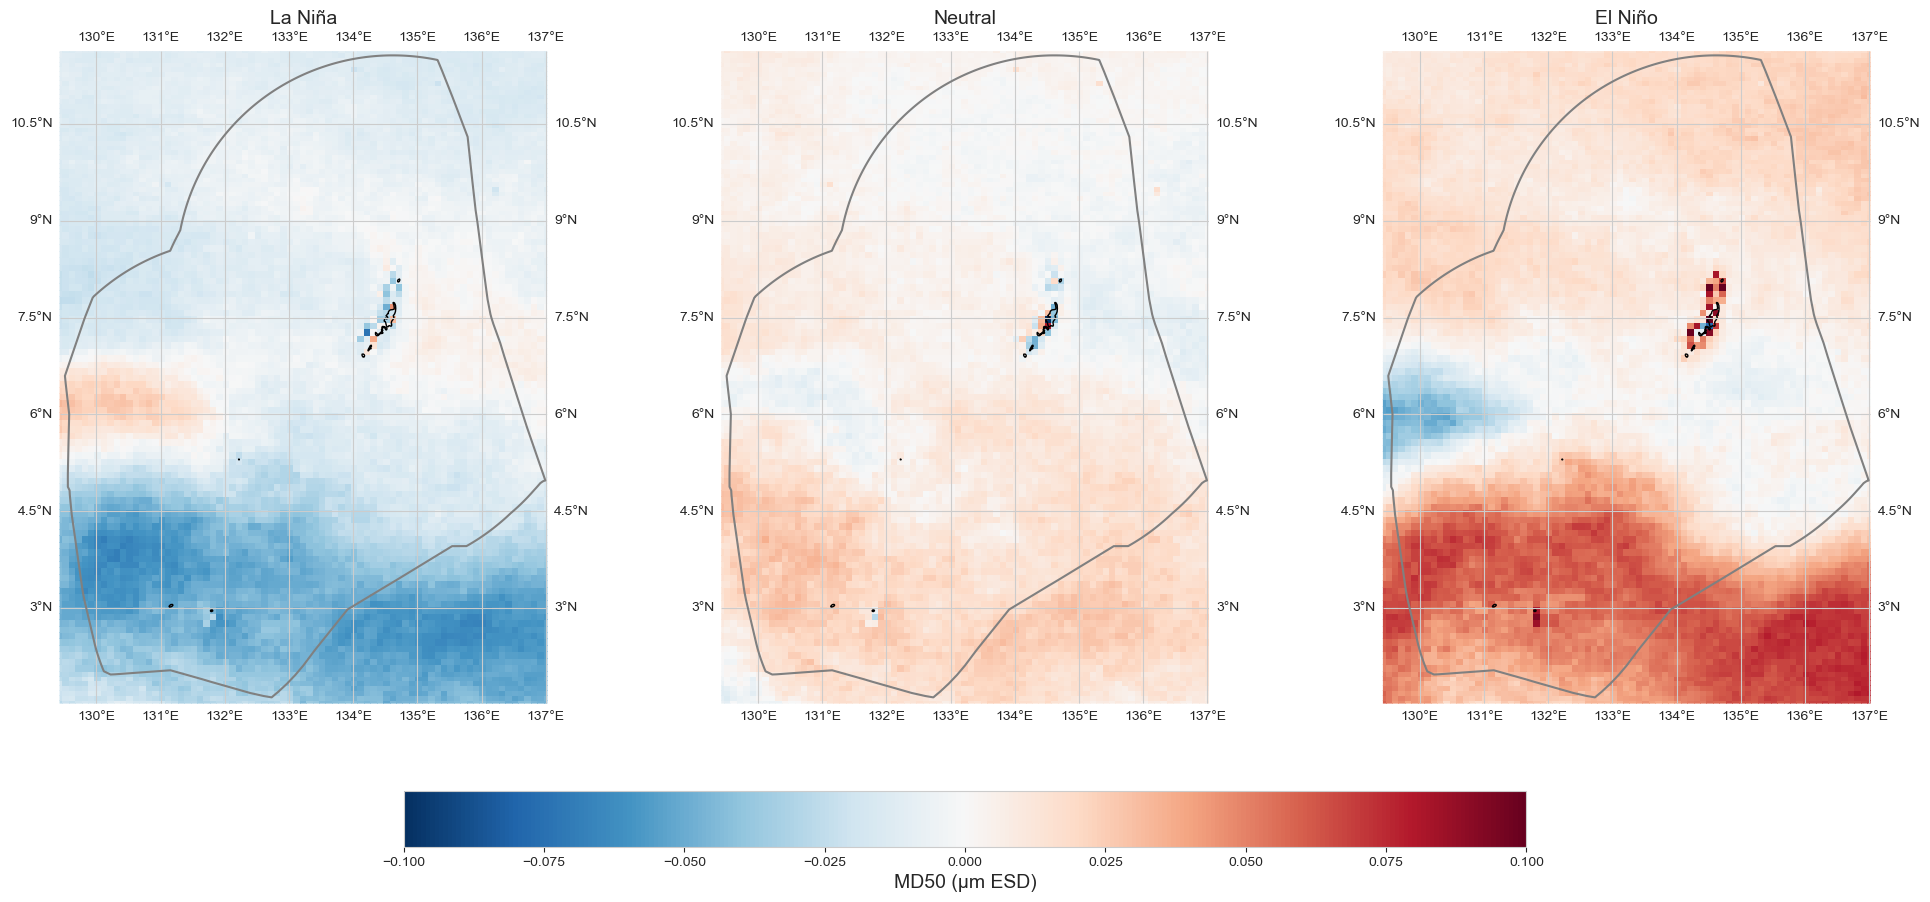

In [19]:
data_an = data_oni - data_xr.mean(dim='time')
fig = plot_map_subplots(data_an, dataset_id, shp_eez = shp_eez, cmap='RdBu_r', vmin=-.1, vmax=.1,
                  sub_plot= [1, 3], figsize = (20, 9),  cbar = True, cbar_pad = 0.1,
                  titles = ['La Niña', 'Neutral', 'El Niño'],)